In [1]:
import numpy as np
np.set_printoptions(linewidth=200, precision=4) # to print wide matrices

import simphony
simphony.Config.set_platform('gpu')
simphony.Config.set_matplotlib_format('retina')
import jax.numpy as jnp
from matplotlib import pyplot as plt

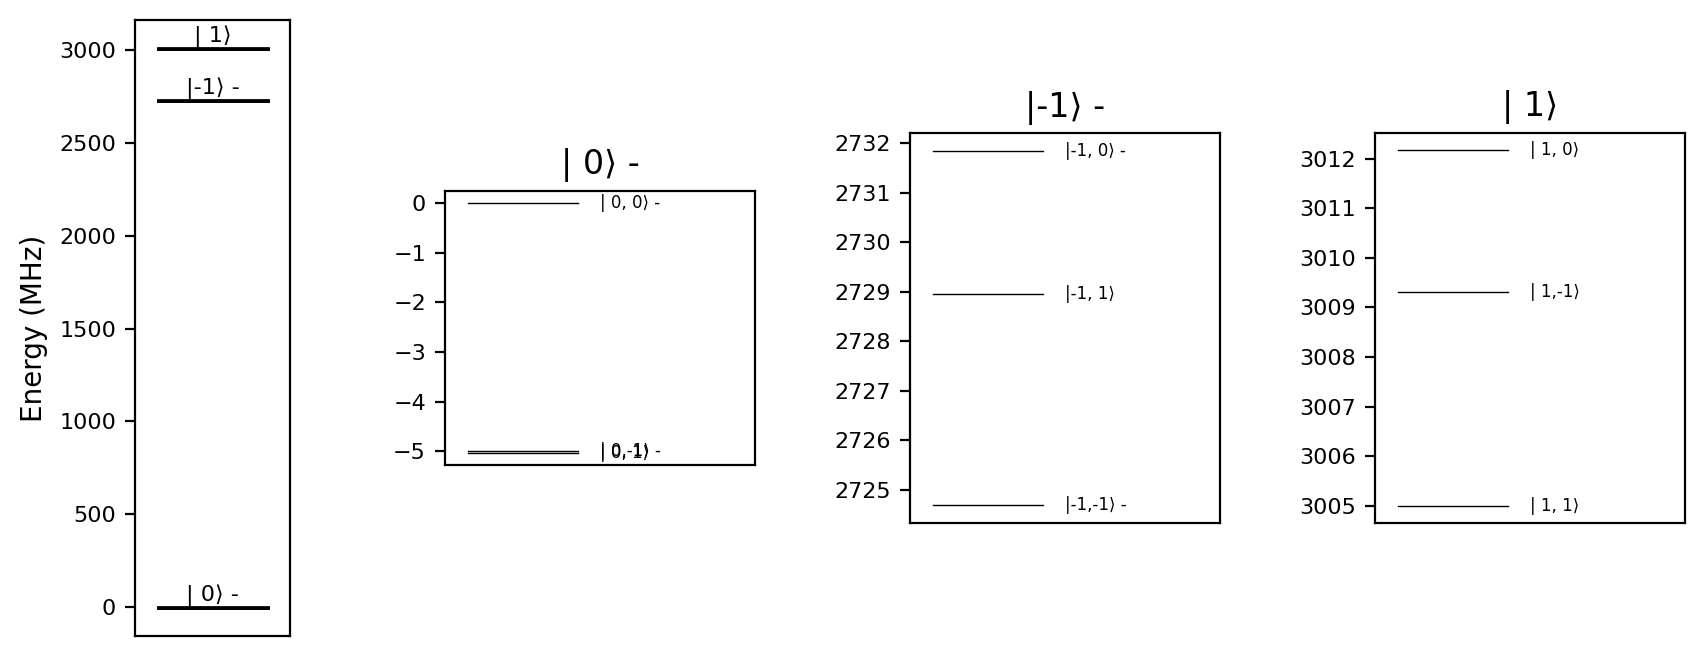

In [2]:
model = simphony.default_nv_model(nitrogen_isotope=14,
                                  static_field_strength=5e-3)
model.plot_levels()

In [31]:
def CPMG_with_AC_field(model, wait, n, f_ac_hz, B_ac_tesla, apply_noise=False, n_shots=1):
    
    duration = 0.01  
    
    frequency = model.splitting_qubit('e', rest_quantum_nums={'N': 0})
    
    angle1 = np.pi / 2
    period_time1 = 2 * np.pi * duration / angle1
    angle2 = np.pi
    period_time2 = 2 * np.pi * duration / angle2
    
    amplitude1 = model.rabi_cycle_amplitude_qubit(
        driving_field_name='MW_x',
        period_time=period_time1,
        spin_name='e'
    )
    amplitude2 = model.rabi_cycle_amplitude_qubit(
        driving_field_name='MW_x',
        period_time=period_time2,
        spin_name='e'
    )
    
   
    f_ac_mhz = f_ac_hz * 1e-6  
    complete_pulse_time = 2 * n * wait + (n + 2) * duration
    
    model.remove_all_pulses()

    model.driving_field('Outside_field').add_rectangle_pulse(amplitude=B_ac_tesla,
                                                             frequency=f_ac_mhz,
                                                             phase=0,
                                                             duration=complete_pulse_time)
    model.driving_field('MW_x').add_rectangle_pulse(
        amplitude=amplitude1,
        frequency=frequency,
        phase=0,
        duration=duration
    )
    
    for i in range(n):
        model.driving_field('MW_x').add_wait(wait)
        model.driving_field('MW_x').add_rectangle_pulse(
            amplitude=amplitude2,
            frequency=frequency,
            phase=np.pi/2,
            duration=duration
        )
        if i != n-1:
            model.driving_field('MW_x').add_wait(wait)
    
    model.driving_field('MW_x').add_wait(wait)
    model.driving_field('MW_x').add_rectangle_pulse(
        amplitude=amplitude1,
        frequency=frequency,
        phase=np.pi, 
        duration=duration
    )
    result = model.simulate_time_evolution(n_eval=2, apply_noise=apply_noise, n_shots=n_shots)
    
    result.initial_state = model.productstate({'e': 0, 'N': 0})
    expectation_value = result.expectation_value('ZI', t_idx=-1, shot='all', frame='rotating')
    
    return expectation_value[:, 0, 0]

In [ ]:
model = simphony.default_nv_model(nitrogen_isotope=14, static_field_strength=5e-3)
model.spin('e').local_quasistatic_noise.z = 0.1


outside_field = simphony.DrivingField(
    direction=[1, 0, 0],  
    name="Outside_field"
)
model.add_driving_field(outside_field)
tau_res = 27e-6
f_ac = 1/4/tau_res
B_ac =  5e-5

print(f"Frequency = {f_ac*1e-6:.4f} MHz")

tau_values = np.linspace(17, 37, 10)  
signals= []
for idx,tau in enumerate(tau_values):
    sig = CPMG_with_AC_field(model, tau, n=10, 
                             f_ac_hz=f_ac, B_ac_tesla=B_ac,
                             apply_noise=True, n_shots=512)
    signals.append(sig)
signals = np.array(signals)

Frequency = 0.0093 MHz


In [ ]:
from scipy.stats import bootstrap
signals_bootstaped = bootstrap((signals,), lambda x, axis: np.mean(x, axis=axis), vectorized=True, axis=1)

signals_mean = np.mean(signals, axis=1)
signals_low = signals_bootstaped.confidence_interval.low
signals_high = signals_bootstaped.confidence_interval.high
signals_err = [signals_high - signals_mean, signals_mean - signals_low]


In [29]:
plt.rcParams.update({'font.size': 14})

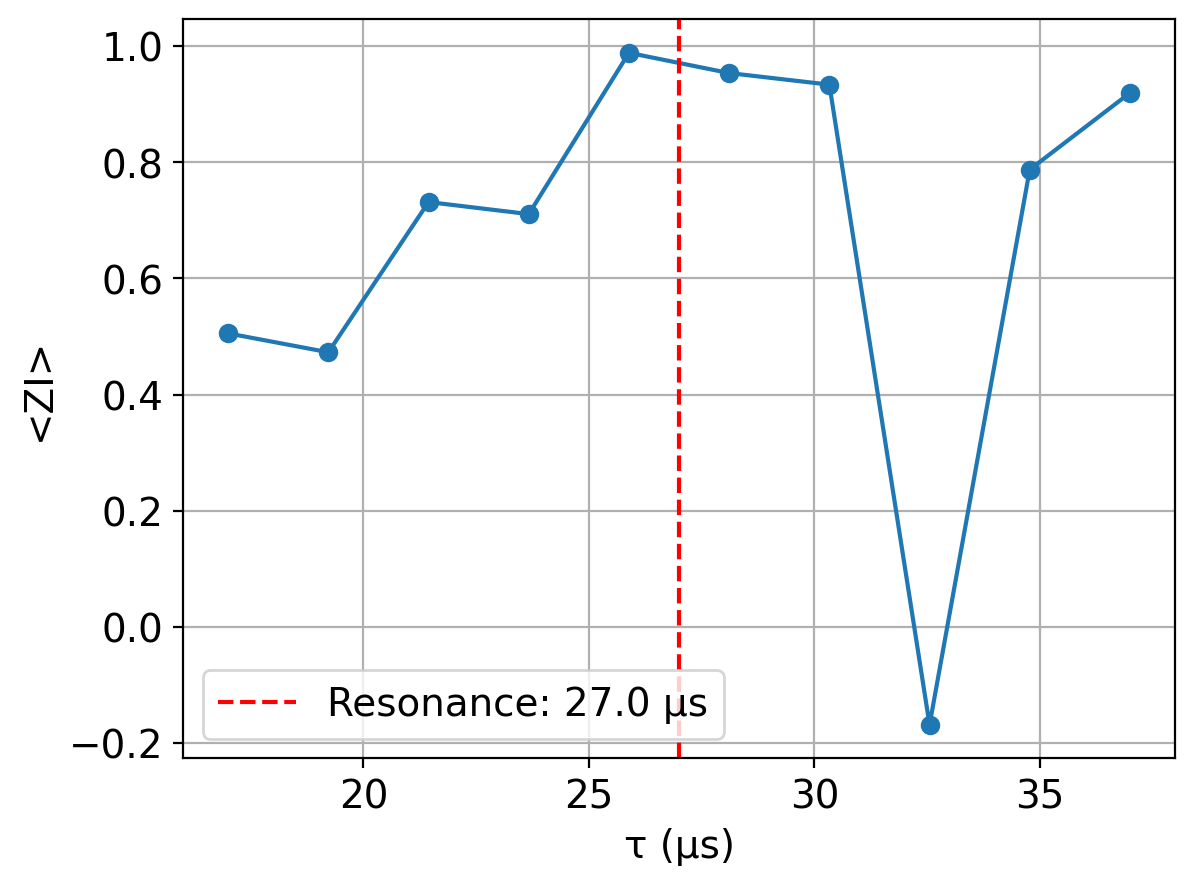

In [30]:
plt.plot(tau_values, signals, 'o-')
plt.axvline(tau_res*1e6, color='r', linestyle='--', label=f'Resonance: {tau_res*1e6:.1f} µs')
plt.xlabel('τ (µs)')
plt.ylabel('<ZI>')
plt.legend()
plt.grid(True)
plt.savefig("Measurement.pdf")